In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat '/content/drive/MyDrive/kaggle/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
ravdess-emotional-speech-audio.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
import os

def unzip_to_directory(zip_file_path, extract_to):
    """
    Unzip a file to the specified directory

    Args:
        zip_file_path (str): Path to the ZIP file
        extract_to (str): Directory where contents will be extracted
    """
    # Create target directory if it doesn't exist
    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f"Extracted {zip_file_path} to {extract_to}")

# Example usage
unzip_to_directory('/content/ravdess-emotional-speech-audio.zip', 'ravdess')

Extracted /content/ravdess-emotional-speech-audio.zip to ravdess


In [ ]:
!pip install audiomentations

In [ ]:
import os
from pathlib import Path
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, TimeDistributed, Flatten, Activation, BatchNormalization, Reshape, Input, Permute
from tensorflow.keras.utils import to_categorical

In [ ]:

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters
SAMPLE_RATE = 22050
DURATION = 3  # seconds
MFCC_NUM = 40
MAX_TIME_STEPS = 130  # Adjusted based on MFCC output
NUM_CLASSES = 8  # RAVDESS emotions: neutral, calm, happy, sad, angry, fearful, disgust, surprised

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5)  # Time shift in seconds
])

def extract_mfcc(file_path, augment = None):
    """Extract MFCC features from audio file."""
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

        if augment:
              audio = augment(audio, sample_rate=SAMPLE_RATE)

        # Pad or trim audio to fixed length
        target_length = SAMPLE_RATE * DURATION
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=MFCC_NUM)
        # Ensure fixed time steps
        if mfcc.shape[1] < MAX_TIME_STEPS:
            mfcc = np.pad(mfcc, ((0, 0), (0, MAX_TIME_STEPS - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :MAX_TIME_STEPS]

        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_ravdess_data(data_path):
    """Load RAVDESS dataset and extract features."""
    X, y = [], []
    a, b, c = [], [], []
    emotions = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }
    intensities = {
        '01': 'normal', '02': 'strong'
    }
    noises = {
        '01': 'Kids are talking by the door', '02': 'Dogs are sitting by the door'
    }
    genders = {
        '01': 'male', '02': 'female', '03': 'male', '04': 'female',
        '05': 'male', '06': 'female', '07': 'male', '08': 'female',
        '09': 'male', '10': 'female', '11': 'male', '12': 'female',
        '13': 'male', '14': 'female', '15': 'male', '16': 'female',
        '17': 'male', '18': 'female', '19': 'male', '20': 'female',
        '21': 'male', '22': 'female', '23': 'male', '24': 'female'
    }

    for dirpath, dirnames, filenames in os.walk(data_path):
        for dirname in dirnames:
            sub_dir = os.path.join(dirpath, dirname)
            for file in os.listdir(sub_dir):
                # Parse filename (e.g., 03-01-01-01-01-01-01.wav)
                parts = file.split('-')
                emotion = emotions.get(parts[2])
                intesity = intensities.get(parts[3])
                noise = noises.get(parts[4])
                gender = genders.get(parts[6].replace('.wav', ''))
                if not emotion:
                    continue
                full_path = os.path.join(sub_dir, file)
                mfcc = extract_mfcc(full_path)
                if mfcc is not None:

                    X.append(mfcc)
                    y.append(emotion)
                    a.append(intesity)
                    b.append(noise)
                    c.append(gender)
    print(c)

    return np.array(X), np.array(y), np.array(a), np.array(b),np.array(c)

def build_cnn_lstm_model(input_shape):
    """Build CNN-LSTM model for emotion classification."""


    # Define two sets of inputs: MFCC and FBANK
    input_y = Input(shape=input_shape, name='Input_MELSPECT')

    ## First LFLB (local feature learning block)
    y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_1_MELSPECT')(input_y)
    y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
    y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
    y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
    y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)

    ## Second LFLB (local feature learning block)
    y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
    y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
    y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
    y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
    y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

    ## Second LFLB (local feature learning block)
    y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
    y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
    y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
    y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
    y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

    ## Second LFLB (local feature learning block)
    y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
    y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
    y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
    y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
    y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)

    # Flat
    y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)

    # Apply 2 LSTM layer and one FC
    y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
    #y = Reshape((MAX_TIME_STEPS, MFCC_NUM))(input_y)
    #y = LSTM(256, input_shape = (MAX_TIME_STEPS, MFCC_NUM),return_sequences=False, dropout=0.2, name='LSTM_1')(y)
    #y = Reshape((256, ))(y)
    y = Dense(y_train.shape[1], activation='softmax', name='FC2')(y)

    # Build final model
    model = Model(inputs=input_y, outputs=y)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'f1_score'])
    return model

    # Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, output_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()


In [ ]:

# Path to RAVDESS dataset (update this to your dataset path)
data_path = "/content/ravdess/audio_speech_actors_01-24"

# Load and preprocess data
X, y, a, b, c = load_ravdess_data(data_path)
if len(X) == 0:
    print("No data loaded. Check dataset path or files.")
    exit()

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, NUM_CLASSES)
print(y)

# Reshape X for CNN-LSTM (add channel dimension)
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2], 1)


# Split data: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_categorical, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42  # 0.15/(1-0.15) to get 15% of original
)



['female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female', 'female',

In [ ]:
# Build model
input_shape = (1, MFCC_NUM,MAX_TIME_STEPS, 1)  # (time, height, width, channels)
model = build_cnn_lstm_model(input_shape)

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_MELSPECT (InputLayer)     │ (None, 1, 40, 130, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1_MELSPECT                 │ (None, 1, 40, 130, 64) │           640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_1_MELSPECT            │ (None, 1, 40, 130, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activ_1_MELSPECT                │ (None, 1, 40, 130, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_1_MELSPECT              │ (None, 1, 20, 65, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_1_MELSPECT                 │ (None, 1, 20, 65, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2_MELSPECT                 │ (None, 1, 20, 65, 64)  │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_2_MELSPECT            │ (None, 1, 20, 65, 64)  │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activ_2_MELSPECT                │ (None, 1, 20, 65, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_2_MELSPECT              │ (None, 1, 5, 17, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_2_MELSPECT                 │ (None, 1, 5, 17, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_3_MELSPECT                 │ (None, 1, 5, 17, 128)  │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_3_MELSPECT            │ (None, 1, 5, 17, 128)  │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Activ_3_MELSPECT                │ (None, 1, 5, 17, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_3_MELSPECT              │ (None, 1, 2, 5, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_3_MELSPECT                 │ (None, 1, 2, 5, 128)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_4_MELSPECT                 │ (None, 1, 2, 5, 128)   │       147,584 │
│ (TimeDistributed)               │                        │             

 Total params: 787,912 (3.01 MB)

 Trainable params: 787,144 (3.00 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        verbose=1
    )

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.1700 - f1_score: 0.1347 - loss: 2.0690 - val_accuracy: 0.1106 - val_f1_score: 0.0249 - val_loss: 2.9507
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2366 - f1_score: 0.1822 - loss: 1.8610 - val_accuracy: 0.1106 - val_f1_score: 0.0249 - val_loss: 3.1475
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2394 - f1_score: 0.1829 - loss: 1.8299 - val_accuracy: 0.1106 - val_f1_score: 0.0249 - val_loss: 2.9200
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2956 - f1_score: 0.2338 - loss: 1.7480 - val_accuracy: 0.1106 - val_f1_score: 0.0256 - val_loss: 2.9145
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3380 - f1_score: 0.2930 - loss: 1.6765 - val_accuracy: 0.1198 - val_f1_score: 0.0415 - val_loss: 2.7020
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3495 - f1_score: 0.3037 - loss: 1.6774 - val_accuracy: 0.1290 - val_f1_score: 0.0558 - va

Test accuracy: 0.3194
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Test Set Results:
Accuracy: 0.3148

Classification Report:
angry:
  Precision: 0.3214
  Recall: 0.8710
  F1-score: 0.4696
calm:
  Precision: 0.8889
  Recall: 0.2286
  F1-score: 0.3636
disgust:
  Precision: 0.1818
  Recall: 0.2500
  F1-score: 0.2105
fearful:
  Precision: 0.4444
  Recall: 0.5217
  F1-score: 0.4800
happy:
  Precision: 0.3043
  Recall: 0.2121
  F1-score: 0.2500
neutral:
  Precision: 0.0000
  Recall: 0.0000
  F1-score: 0.0000
sad:
  Precision: 0.1667
  Recall: 0.0357
  F1-score: 0.0588
surprised:
  Precision: 0.2059
  Recall: 0.2500
  F1-score: 0.2258
macro avg:
  Precision: 0.3142
  Recall: 0.2961
  F1-score: 0.2573
weighted avg:
  Precision: 0.3525
  Recall: 0.3148
  F1-score: 0.2759


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{np.str_('female'): 0.23148148148148148, np.str_('male'): 0.08333333333333333}


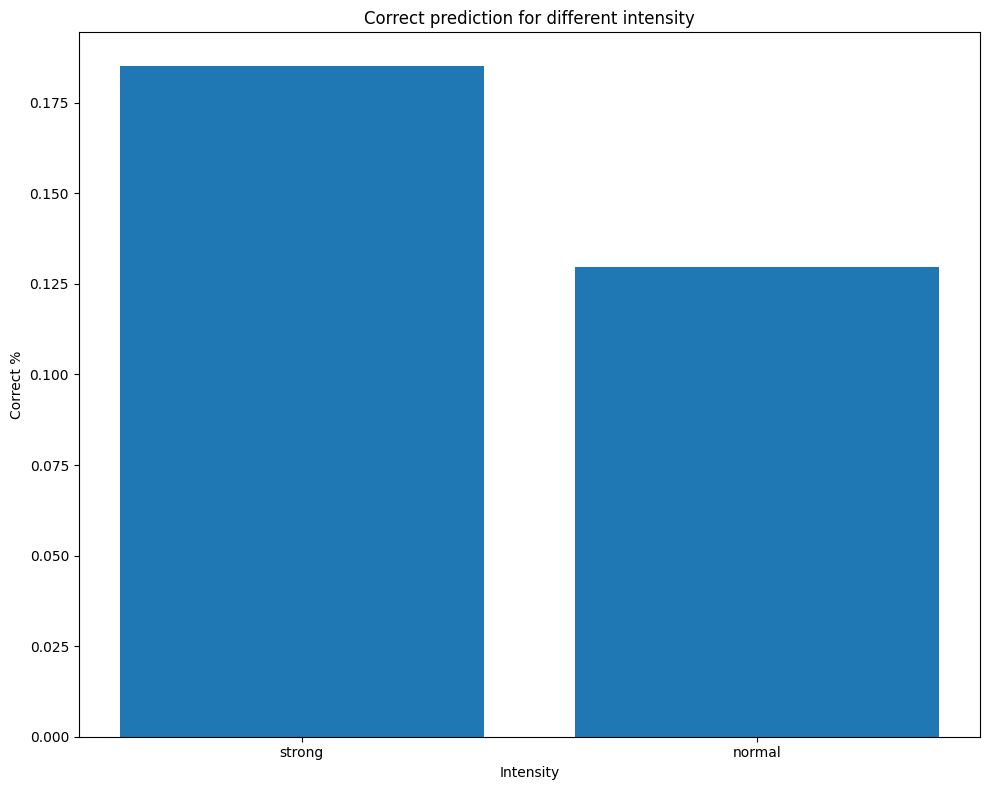

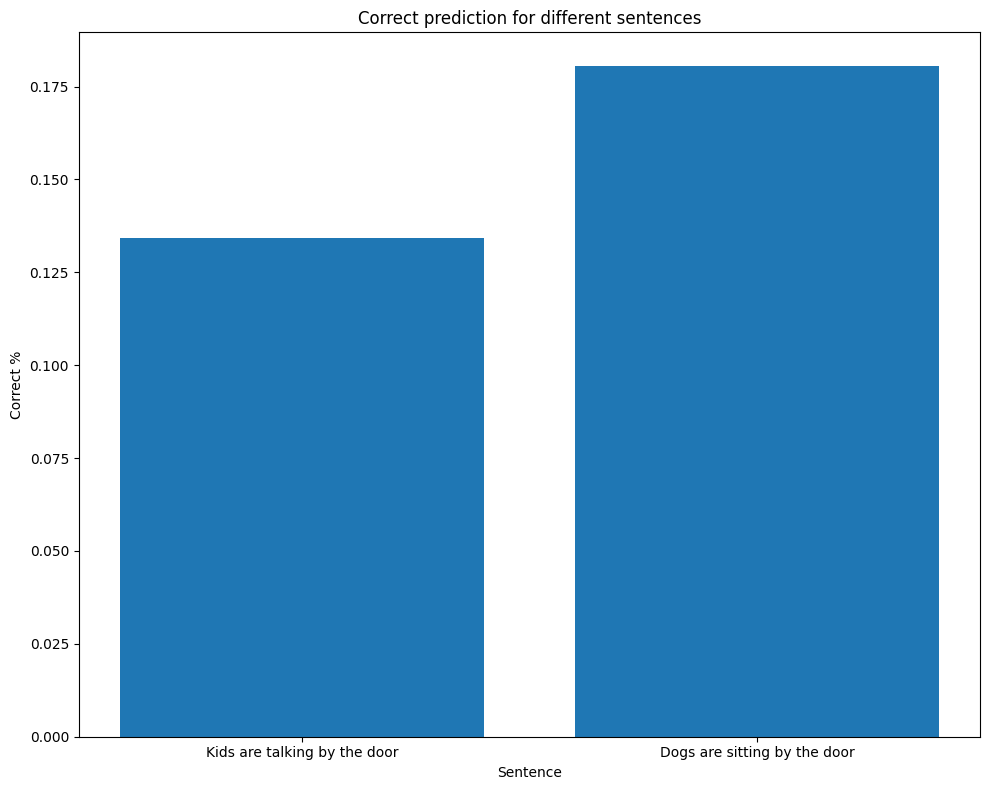

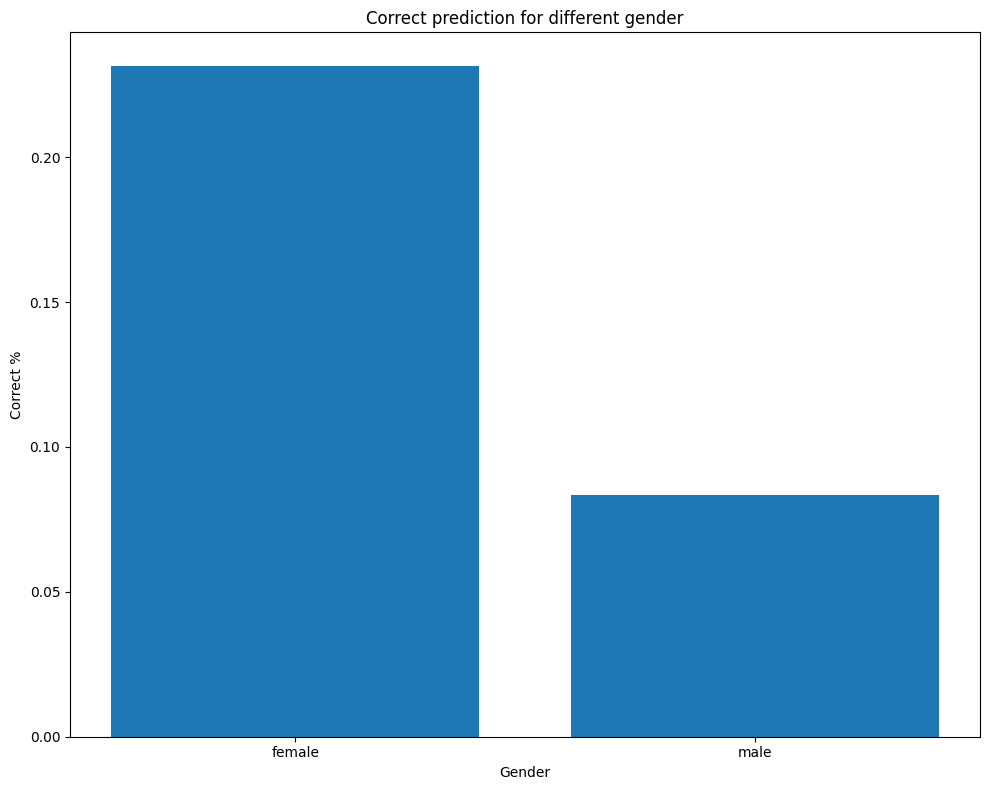

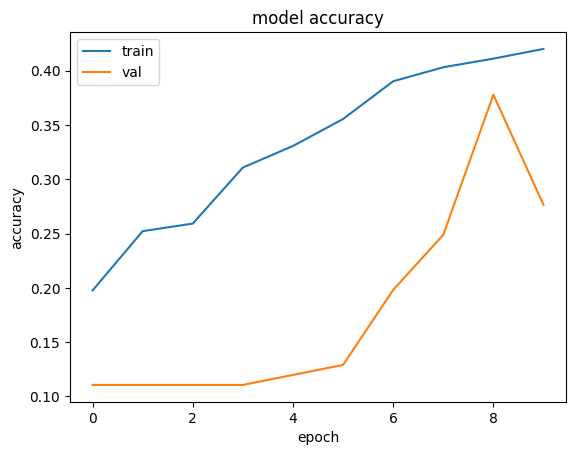

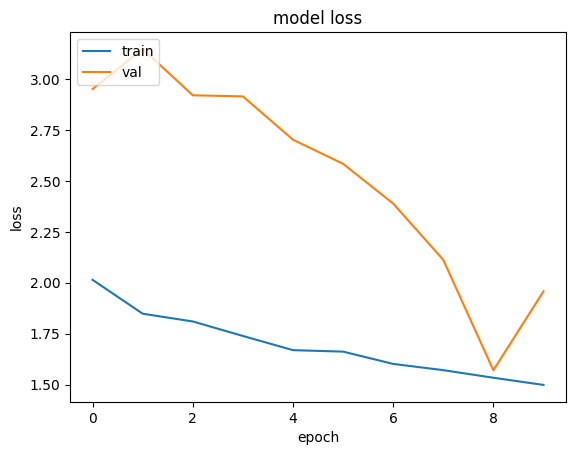

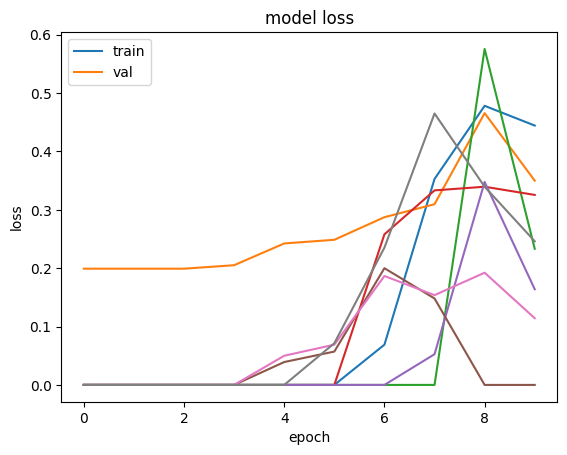

In [ ]:
    from collections import defaultdict
    # Compute metrics
    def compute_score(pred, labels, a):
        d = dict()
        for i, v in enumerate(pred==labels):
            if v:
              if a[i] in d:
                d[a[i]] += 1
              else:
                d[a[i]] = 1

        for k in d:
          d[k] /=len(labels)

        return d

    def compute_metrics(pred, labels, a, b, c):
        accuracy = accuracy_score(labels, pred)
        report = classification_report(labels, pred, target_names=le.classes_, output_dict=True)

        return accuracy, report, compute_score(pred, labels, a), compute_score(pred, labels, b), compute_score(pred, labels, c)
    # Evaluate model on test set
    test_loss, test_accuracy,test_f1_score = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Generate predictions for classification report and confusion matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Classification report
    test_accuracy, test_report, ad, bd, cd= compute_metrics(y_pred_classes, y_test_classes, a, b, c)
    print("\nTest Set Results:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print("\nClassification Report:")
    for emotion, metrics in test_report.items():
        if isinstance(metrics, dict):
            print(f"{emotion}:")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall: {metrics['recall']:.4f}")
            print(f"  F1-score: {metrics['f1-score']:.4f}")
    # Confusion matrix
    plot_confusion_matrix(y_test_classes, y_pred_classes, le.classes_, 'confusion_matrix.png')

    def plot_bar(a, title, y, x):
      plt.figure(figsize=(10, 8))
      plt.bar(range(len(a)), list(a.values()), align='center')
      plt.xticks(range(len(a)), list(a.keys()))
      plt.title(title)
      plt.ylabel(y)
      plt.xlabel(x)
      plt.tight_layout()
      plt.show()
    print(cd)
    plot_bar(ad, "Correct prediction for different intensity", 'Correct %', "Intensity")
    plot_bar(bd, "Correct prediction for different sentences", 'Correct %', "Sentence")
    plot_bar(cd, "Correct prediction for different gender", 'Correct %', "Gender")
    # Save model
    model.save('cnn_lstm_ravdess.h5')

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


    plt.plot(history.history['val_f1_score'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Save label encoder
    np.save('label_encoder_classes.npy', le.classes_)
